In [1]:
import jax
# jax.config.update('jax_platform_name', 'cpu')  # https://github.com/google/jax/issues/1598#issuecomment-718621972
import jax.numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

import softras
import razor

In [2]:
def load_basel():
    bm = np.load('basel_cmplx.npz')
    sm, sb, sv = bm['sm'], bm['sb'], bm['sv']
    cm, cb, cv = bm['cm'], bm['cb'], bm['cv']
    em, eb, ev = bm['em'], bm['eb'], bm['ev']
    tri = bm['tri']
    z_s_n = sv.shape
    z_c_n = cv.shape
    z_e_n = ev.shape
    return (z_s_n, z_c_n, z_e_n), (sm, sb, sv, cm, cb, cv, em, eb, ev, tri)

In [3]:
pixel, shape = softras.get_pixel(-0.8, 0.8, +0.8, -0.8, 64, 64)
(z_s_n, z_c_n, z_e_n), basel_params = load_basel()
print(f'z_s_n: {z_s_n}')
print(f'z_c_n: {z_c_n}')
print(f'z_e_n: {z_e_n}')
print(f'n: {basel_params[0].shape[0]}')

def make_basel(basel_params, z_shape, z_color, z_expr, theta, phi1, phi2):
    (sm, sb, sv, cm, cb, cv, em, eb, ev, tri) = basel_params

    s = np.matmul(sb, z_shape * sv) + sm
    c = np.matmul(cb, z_color * cv) + cm
    e = np.matmul(eb, z_expr * ev) + em
    s = s + e
    N = tri.shape[0]

    vert = s
    vert = vert - vert.mean(axis=0)
    vert = vert / np.abs(vert).max()
    mesh = np.array(vert[tri])

    text = (c[tri[:, 0]] + c[tri[:, 1]] + c[tri[:, 2]]) / 3
    text = text.mean(axis=1)

    proj = softras.apply_homogeneous_transform(softras.make_rotation_Y(theta * 0.01 + np.pi), mesh)
#     proj = softras.apply_translation(proj, dx, dy, 0.)

    light_dir = np.stack([phi1, phi2, -1.])
    normals = np.cross(proj[:, 1] - proj[:, 0], proj[:, 2] - proj[:, 0])
    normals = normals / np.linalg.norm(normals, axis=1, keepdims=True)
    C = np.abs(np.dot(normals, light_dir)) * text + 0.001

    face = softras.softras(proj, pixel, C, SIGMA=1e-3).reshape(shape)
    mooney = np.tanh((face - np.percentile(face, 80)) * 20)
    return mooney, face

z_s_n: (199,)
z_c_n: (199,)
z_e_n: (100,)
n: 265


  0%|          | 0/1 [00:00<?, ?it/s]

(-0.5, 63.5, 63.5, -0.5)

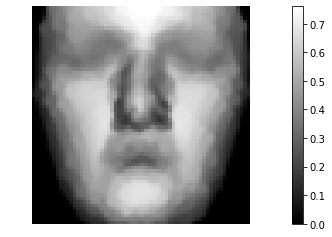

In [4]:
for _ in tqdm([1]):
    mooney, face = make_basel(
        basel_params,
        z_shape=-np.ones(shape=z_s_n),
        z_color=np.zeros(shape=z_c_n),
        z_expr=-np.ones(shape=z_e_n),
        theta=0,
        phi1=0,
        phi2=0
    )

plt.colorbar(plt.imshow(face.reshape(shape), cmap='gray'))
plt.axis('off')
plt.axis('equal')

In [5]:
class mooney_basel(razor.Model):
    def forward(self, t, obs):
        z_shape = t.gaussian_sample(shape=z_s_n)
        z_color = t.gaussian_sample(shape=z_c_n)
        z_expr = t.gaussian_sample(shape=z_e_n)

        theta = t.gaussian_sample(shape=())
        phi1 = t.gaussian_sample(shape=())
        phi2 = t.gaussian_sample(shape=())

        mooney, face = make_basel(
            basel_params,
            z_shape=z_shape,
            z_color=z_color,
            z_expr=z_expr,
            theta=np.tanh(theta),
            phi1=np.tanh(phi1),
            phi2=np.tanh(phi2)
        )
        t.gaussian_observe(face, 0.1, obs)

m = mooney_basel(face)
print(f'Mooney model has {m.N} parameters')
def params_from_sample(sample):
    return (
        basel_params,
        sample[:z_s_n[0]],
        sample[z_s_n[0]:z_s_n[0] + z_c_n[0]],
        sample[z_s_n[0] + z_c_n[0]:z_s_n[0] + z_c_n[0] + z_e_n[0]],
        np.tanh(sample[-3]),
        np.tanh(sample[-2]),
        np.tanh(sample[-1])
    )

Mooney model has 501 parameters


In [6]:
mode = 'monalisa'


def loss(grid, key, q0, q0_):
    obs = make_basel(*params_from_sample(grid))[1]
    obs_ = make_basel(*params_from_sample(grid.at[-2:].set(-grid[-2:])))[1]

    samples = razor.hmc_sample(
        m, q0, key, 10, 5, 0, 1e-2,
        obs
    )

    samples_ = razor.hmc_sample(
        m, q0_, key, 10, 5, 0, 1e-2,
        obs_
    )

    return (
        -np.mean(np.abs(
            params_from_sample(samples[-1])[3][:10] -
            params_from_sample(samples_[-1])[3][:10]
        )) + -np.mean(np.abs(
            params_from_sample(samples[-1])[1][:10] -
            params_from_sample(samples_[-1])[1][:10]
        )) + np.mean(obs ** 2),
        (obs, obs_, samples, samples_)
    )

dloss = jax.value_and_grad(loss, has_aux=True, argnums=0)

  0%|          | 0/21 [00:00<?, ?it/s]

seed=64, iter=0, loss=-0.1509110927581787, maxdl=0.7724835872650146


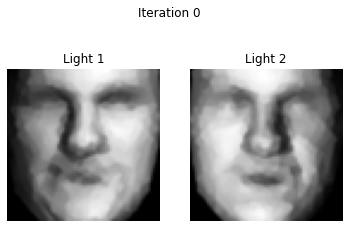

seed=64, iter=5, loss=-0.1281314194202423, maxdl=0.7381446361541748


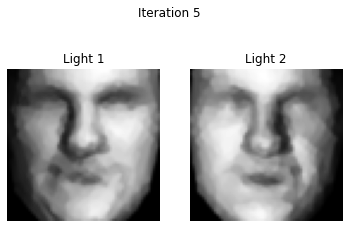

seed=64, iter=10, loss=-0.41788437962532043, maxdl=0.1437089443206787


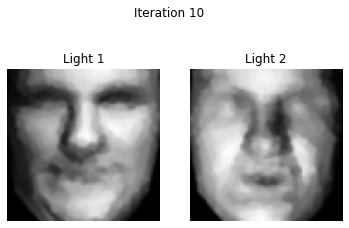

seed=64, iter=15, loss=-0.4921741485595703, maxdl=0.05109964683651924


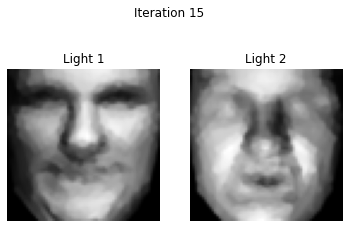

seed=64, iter=20, loss=-0.5509604215621948, maxdl=0.05538360774517059


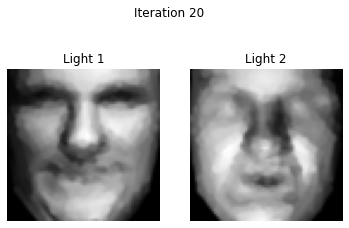

In [7]:
from IPython.display import display

for seed in [64]:#tqdm(range(100)):
    key = jax.random.PRNGKey(seed)

    key, subkey = jax.random.split(key)
    grid = jax.random.normal(subkey, shape=(m.N,))

    q0 = np.zeros(m.N)
    q0_ = np.zeros(m.N)
    
    obs0 = make_basel(*params_from_sample(grid))[1]
    obs0_ = make_basel(*params_from_sample(grid.at[-2:].set(-grid[-2:])))[1]

    for i in tqdm(range(20 + 1), leave=False):
        q0 = np.zeros(m.N)
        q0_ = np.zeros(m.N)
        
        key, subkey = jax.random.split(key)
        (l, (obs, obs_, samples, samples_)), dl = dloss(grid, subkey, q0, q0_)
        q0 = samples[-1]
        q0_ = samples_[-1]

        if i > 5:
            grid = grid - 1e0 * np.clip(dl, -0.1, 0.1)

        if i % 5 == 0:
            np.save(f'out/face-perception/{seed:02}-{i:04}', grid)
            print(f'seed={seed}, iter={i}, loss={l}, maxdl={np.max(np.abs(dl))}')

            fig = plt.figure()
            plt.suptitle(f'Iteration {i}')

            plt.subplot(1, 2, 1)
            plt.title('Light 1')
            plt.imshow(obs, cmap='gray')
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.title('Light 2')
            plt.imshow(obs_, cmap='gray')
            plt.axis('off')

            mooney, face = make_basel(*params_from_sample(q0))
            mooney_, face_ = make_basel(*params_from_sample(q0_))

            display(fig)
            plt.savefig(f'out/face-perception/out-{seed:02}-{i:04}.jpg')
            plt.close()

    frames = []
    for z in np.linspace(-1., +1., 32):
        img = make_basel(*params_from_sample(grid.at[-2:].set(z * grid[-2:])))[1]
        img = img / np.max(img)
        img = np.round(img * 255).astype(np.uint8)
        frames.append(img)
    frames = frames + list(reversed(frames))
    import imageio
    imageio.mimsave(f'out/face-perception/{seed:02}.gif', frames, fps=32)